In [1]:
from common_lib import DataManager
from common_lib import AnnotationManager

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import timm
import cv2

### 相关配置

In [21]:
batch_size = 16
seed = 42
lr = 0.003
epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def seed_everything(seed): #将所有的随机变量设置其随机种子
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

### 数据加载

In [5]:
img_root = "F:/mountMl_fan/bearing/"

In [6]:
train_data = DataManager.load("./jsons/train.json")
val_data = DataManager.load("./jsons/val.json")
test_data = DataManager.load("./jsons/test.json")

In [7]:
am = AnnotationManager(train_data.class_dict)
am.setup_distribution_type(
    distribution_type = 'multiclass'
)

In [8]:
# def get_img(path):
#     im_bgr = cv2.imread(path)
#     im_rgb = im_bgr[:, :, ::-1]
#     #print(im_rgb)
#     return im_rgb

In [9]:
class CharacterDataset(Dataset): #定义数据集 定义len getitem函数 重写len 和getitem魔法方法
    def __init__(self, data,am,_root,transform=None):  #设置文件和对应的转换操作
        self.file= data
        self.transform = transform
        self.img_root = img_root
        self.am = am
    def __len__(self):
        self.filelen = len(self.file)
        return self.filelen

    def __getitem__(self, idx): #p[key] 取值，当实例对象做p[key] 运算时，会调用类中的方法__getitem__
        rec = self.file[idx]
        img_path = self.img_root+rec['info']['image_path']
        img = Image.open(img_path)
#         img = img.convert("RGB")
        img_transformed = self.transform(img)
#         am = AnnotationManager(self.file.class_dict)
        label = self.am.get_classid(rec)[0] #使用传入的am 形式为[0] 选取[0]
#         label = img_path.split(os.path.sep)[-1].split(".")[0]
#         label = 1 if label == "dog" else 0 #如果标签为dog 则设置为1 否则为0（狗为1 猫为0）
        return img_transformed, label

In [10]:
#训练集 验证集 测试集 处理为相同的图像增强操作
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # 将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为制定的大小；
#         transforms.RandomHorizontalFlip(),  # 以给定的概率随机水平旋转给定的PIL的图像，默认为0.5；
        transforms.ToTensor(),              # 归一化 并且转化为张量
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [11]:
train_dataset = CharacterDataset(train_data,am,img_root, transform=train_transforms)  
valid_dataset = CharacterDataset(val_data,am,img_root, transform=test_transforms)
test_dataset = CharacterDataset(test_data,am,img_root, transform=test_transforms)

In [12]:
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
len(distribution_classes)

36

torch.Size([16, 1, 224, 224])
tensor([ 6,  6,  2, 17, 11, 34, 17, 17,  2, 17,  6,  2,  6,  2,  0, 15])


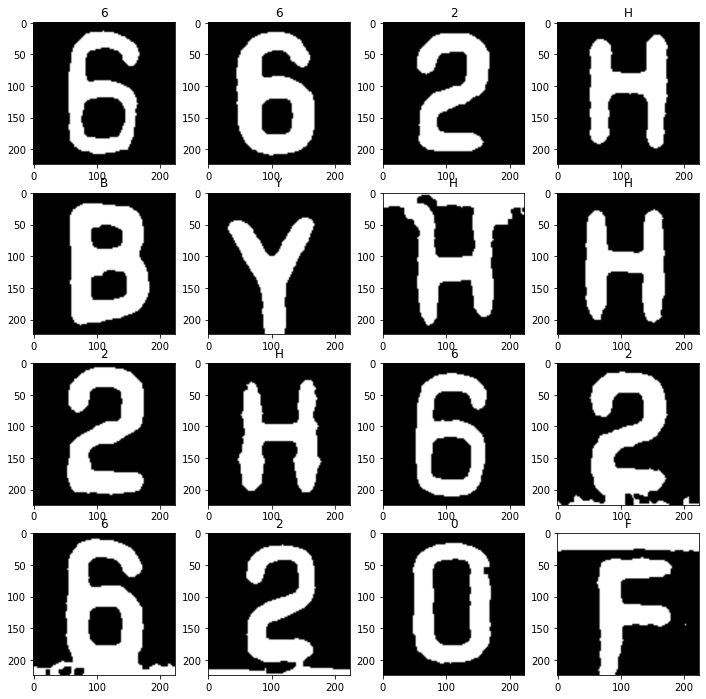

In [14]:
for data,label in test_loader:
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    print(data.shape)
    print(label)
    for idx, ax in enumerate(axes.ravel()):
        img = data[idx].permute(1, 2, 0)
        ax.set_title(distribution_classes[label[idx]]) #轴添加
        ax.imshow(img,cmap="gray")
    break

In [15]:
print(f"train_loader lenth:{len(train_loader)}")
print(f"valid_loader lenth:{len(valid_loader)}")
print(f"train_dataset lenth:{len(train_dataset)}")
print(f"valid_dataset lenth:{len(valid_dataset)}")

train_loader lenth:2237
valid_loader lenth:38
train_dataset lenth:35792
valid_dataset lenth:593


### 模型训练

In [16]:
print("Available Vision Transformer Models：")
timm.list_models()

Available Vision Transformer Models：


['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [17]:
# m = timm.create_model('resnet34', pretrained=True, in_chans=1,num_classes=36)

# # single channel image
# x = torch.randn(16, 1, 224, 224)

# m(x).shape

In [22]:
class ViTBase16(nn.Module):
    def __init__(self,n_classes,pretrained = False):
        super(ViTBase16,self).__init__()
        self.model = timm.create_model("levit_128s",pretrained=pretrained,in_chans =1,num_classes=n_classes)
        
    def forward(self,x):
#         print(x.shape)
        x = self.model(x)
#         x = torch.softmax(x,dim =  -1)  #无需sofemax 因为在CrossentropyLoss 中默认加上了softmax计算loss值
#         print(x.shape)
#         print("before",x)
        return x
    def train_one_epoch(self,train_loader,criterion,optimizer,device):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        self.model.train()
        for i,(data,target) in enumerate(train_loader): #每一个批次的最后进行参数更新
            if device.type=="cuda":
                data,target = data.cuda(),target.cuda()
            optimizer.zero_grad()  #变量的梯度清零
            output,aux = self.forward(data) #训练输出结果
#             output = self.forward(data) #训练输出结果
            
            loss = criterion(output,target) #求解loss
            loss.backward() #计算每个参数的梯度值
            accuracy = (output.argmax(dim=1)==target).float().mean()
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()  #参数根据梯度进行更新
            if(i%100==99):
                print(f"第{i+1}批次 loss: {loss:.4f} acc: {accuracy:.4f}\n")
        return epoch_loss/len(train_loader),epoch_accuracy/len(train_loader)
    def validation_one_epoch(self,valid_loader,criterion,device):
        valid_loss = 0.0
        valid_accuracy = 0.0
        self.model.eval()   #可以屏蔽BN层和dropout
        for data,target in valid_loader:
            if device.type=="cuda":
                data,target = data.cuda(),target.cuda()
            with torch.no_grad():
                output = self.model(data)
                loss = criterion(output,target)
                accuracy = (output.argmax(dim=1)==target
                           ).float().mean() #求解此批次的acc
                valid_loss+=loss
                valid_accuracy+=accuracy
        return valid_loss/len(valid_loader),valid_accuracy/len(valid_loader)


In [23]:
model = ViTBase16(n_classes=len(am._leaf_classes),pretrained=True)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
for epoch in range(epochs):
    print(f"第{epoch+1}轮---------------------------------》》》》》》\n")
    epoch_loss,epoch_accuracy = model.train_one_epoch(train_loader, criterion, optimizer, device)
    epoch_val_loss,epoch_val_accuracy = model.validation_one_epoch(valid_loader,criterion,device)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

第1轮---------------------------------》》》》》》

第100批次 loss: 1.6358 acc: 0.5625

第200批次 loss: 0.5659 acc: 0.8125

第300批次 loss: 0.4753 acc: 0.9375

第400批次 loss: 0.5345 acc: 0.8125

第500批次 loss: 0.2385 acc: 0.8750

第600批次 loss: 0.9532 acc: 0.7500

第700批次 loss: 0.7488 acc: 0.8125

第800批次 loss: 0.3265 acc: 0.8750

第900批次 loss: 0.5047 acc: 0.9375

第1000批次 loss: 0.3851 acc: 0.8750

第1100批次 loss: 0.4137 acc: 0.8750

第1200批次 loss: 0.3095 acc: 0.9375

第1300批次 loss: 0.5619 acc: 0.8750

第1400批次 loss: 0.7593 acc: 0.8125

第1500批次 loss: 0.5532 acc: 0.8125

第1600批次 loss: 0.2258 acc: 0.9375

第1700批次 loss: 0.6978 acc: 0.7500

第1800批次 loss: 0.8384 acc: 0.7500

第1900批次 loss: 0.2342 acc: 0.8750

第2000批次 loss: 0.2261 acc: 0.8750

第2100批次 loss: 0.0480 acc: 1.0000

第2200批次 loss: 0.3367 acc: 0.9375

Epoch : 1 - loss : 0.5868 - acc: 0.8362 - val_loss : 0.5959 - val_acc: 0.9046

第2轮---------------------------------》》》》》》

第100批次 loss: 0.0538 acc: 1.0000

第200批次 loss: 0.1363 acc: 0.9375

第300批次 loss: 0.9236 acc: 0.8

In [25]:
test_loss,test_accuracy = model.validation_one_epoch(test_loader,criterion,device)
print(
        f" loss : {test_loss:.4f} - acc: {test_accuracy:.4f}\n"
    )

 loss : 0.2460 - acc: 0.9883



In [26]:
torch.save(model.state_dict(),"./models/levit128s.pt")

### vit_deit_small_distilled_patch16_224

In [15]:
class ViTBase16(nn.Module):
    def __init__(self,n_classes,pretrained = False):
        super(ViTBase16,self).__init__()
        self.model = timm.create_model("tf_efficientnet_b2",pretrained=pretrained,in_chans =1,num_classes=n_classes)
        
    def forward(self,x):
#         print(x.shape)
        x = self.model(x)
#         x = torch.softmax(x,dim =  -1)  #无需sofemax 因为在CrossentropyLoss 中默认加上了softmax计算loss值
#         print(x.shape)
#         print("before",x)
        return x
    def train_one_epoch(self,train_loader,criterion,optimizer,device):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        self.model.train()
        for i,(data,target) in enumerate(train_loader): #每一个批次的最后进行参数更新
            if device.type=="cuda":
                data,target = data.cuda(),target.cuda()
            optimizer.zero_grad()  #变量的梯度清零
#             output,aux = self.forward(data) #训练输出结果
            output = self.forward(data) #训练输出结果
            loss = criterion(output,target) #求解loss
            loss.backward() #计算每个参数的梯度值
            accuracy = (output.argmax(dim=1)==target).float().mean()
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()  #参数根据梯度进行更新
            if(i%100==99):
                print(f"第{i+1}批次 loss: {loss:.4f} acc: {accuracy:.4f}\n")
        return epoch_loss/len(train_loader),epoch_accuracy/len(train_loader)
    def validation_one_epoch(self,valid_loader,criterion,device):
        valid_loss = 0.0
        valid_accuracy = 0.0
        self.model.eval()   #可以屏蔽BN层和dropout
        for data,target in valid_loader:
            if device.type=="cuda":
                data,target = data.cuda(),target.cuda()
            with torch.no_grad():
                output = self.model(data)
                loss = criterion(output,target)
                accuracy = (output.argmax(dim=1)==target
                           ).float().mean() #求解此批次的acc
                valid_loss+=loss
                valid_accuracy+=accuracy
        return valid_loss/len(valid_loader),valid_accuracy/len(valid_loader)


In [ ]:
modelVit = ViTBase16(n_classes=len(am._leaf_classes),pretrained=True)
modelVit.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelVit.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    print(f"第{epoch+1}轮---------------------------------》》》》》》\n")
    epoch_loss,epoch_accuracy = modelVit.train_one_epoch(train_loader, criterion, optimizer, device)
    epoch_val_loss,epoch_val_accuracy = modelVit.validation_one_epoch(valid_loader,criterion,device)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
test_loss,test_accuracy = modelVit.validation_one_epoch(test_loader,criterion,device)
print(
        f" loss : {test_loss:.4f} - acc: {test_accuracy:.4f}\n"
    )

# 只保存模型的参数字典

In [ ]:
torch.save(model.state_dict(),"./models/resnet34.pt")

## 结果写入

In [ ]:
len(test_loader)

In [ ]:
def test_evaluate(model,test_loader,criterion,device):
    test_loss = 0.0
    test_accuracy = 0.0
    model.eval()   #可以屏蔽BN层和dropout
    output_test = []
    for data,target in test_loader:
        if device.type=="cuda":
            data,target = data.cuda(),target.cuda()
        with torch.no_grad():
            output = model(data)
            output_test.append(output)
            loss = criterion(output,target)
            accuracy = (output.argmax(dim=1)==target
                        ).float().mean() #求解此批次的acc
            test_loss+=loss
            test_accuracy+=accuracy
    return test_loss/len(test_loader),test_accuracy/len(test_loader),output_test

In [ ]:
test_loss,test_accuracy ,output_test = test_evaluate(model,test_loader,criterion,device)
print(
        f" loss : {test_loss:.4f} - acc: {test_accuracy:.4f}\n"
    )

In [ ]:
test_result = []
for batch in output_test:
    batch_result = torch.softmax(batch,dim =  -1)
    test_result += batch_result.tolist()
    
print(len(test_result))    

In [ ]:
len(test_result[0])

In [ ]:
# # create json
#
record_list = list()
class_dict = test_data.class_dict
am = AnnotationManager(class_dict)
am.setup_distribution_type(
#     distribution_classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'],
    distribution_classes = am._leaf_classes,
    distribution_type = 'multiclass'
)
for i,record in enumerate(test_data):
#     dist = [0.3, 0.7]  # dist is the output of your model
    dist = test_result[i]
    instance = am.create_instance(dist)
    record_list.append(
        {
            'info': record['info'],
            'instances': [instance]
        }
    )


data_out = DataManager(record_list, class_dict)
data_out.save('./jsons/test_pred.json')

In [ ]:
# 输出所有内容
np.set_printoptions(threshold=np.inf) #显示所有内容

In [ ]:
#
# Evaluation
#
from common_lib import MultiClassEvaluator

ev = MultiClassEvaluator()

ev.load_annotation('jsons/test.json')
ev.load_prediction('jsons/test_pred.json')

classesname = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
ev.set_classnames(classesname)
ev.eval(verbose=True)